In [1]:
import torch
from torch.nn import functional as F
import glob
import importlib
from tqdm import tqdm
import numpy as np
import pathlib
from unet import UNet
from additional_layers import nrmse
import dataloader
from utils import sum_of_squares
import transforms
import sampling
importlib.reload(dataloader)
importlib.reload(transforms)

<module 'transforms' from '/home/md/Documents/MasterSemester3/PracticalCourse/NeuralNets/JNotebooks/Dataloader/transforms.py'>

In [2]:
def data_ifft_transform(kspace, sampling_dist):
    
    #a = datetime.datetime.now()
    kspace_us = transforms.apply_sampling(kspace, sampling_dist)
    #b = datetime.datetime.now()
    #c = (b-a)
    #print('first', 'Sec: ', c.seconds, 'Micro: ', c.microseconds)
    
    #a = datetime.datetime.now()
    kspace_us = transforms.to_tensor(kspace_us) 
    #b = datetime.datetime.now()
    #c = (b-a)
    #print('second', 'Sec: ', c.seconds, 'Micro: ', c.microseconds)
    
    #a = datetime.datetime.now()
    img = transforms.ifft2(kspace_us) 
    #b = datetime.datetime.now()
    #c = (b-a)
    #print('third', 'Sec: ', c.seconds, 'Micro: ', c.microseconds)
    
    #a = datetime.datetime.now()
    img = transforms.complex_abs(img)
    #b = datetime.datetime.now()
    #c = (b-a)
    #print('fourth', 'Sec: ', c.seconds, 'Micro: ', c.microseconds)
    
    #a = datetime.datetime.now()
    img = transforms.sum_of_squares(img)
    #b = datetime.datetime.now()
    #c = (b-a)
    #print('fifth', 'Sec: ', c.seconds, 'Micro: ', c.microseconds)
    
    #a = datetime.datetime.now()
    img = img.unsqueeze(0)
    #b = datetime.datetime.now()
    #c = (b-a)
    #print('sixth', 'Sec: ', c.seconds, 'Micro: ', c.microseconds)
    
    return img

In [3]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

In [4]:
trainPath = '/media/md/TOSHIBA EXT/MRI_Images/train_val_12_channel/Train/'
valPath = '/media/md/TOSHIBA EXT/MRI_Images/train_val_12_channel/Val/'
trainPathSSD = '/home/md/Documents/MasterSemester3/PracticalCourse/NeuralNets/Data/Train/'
valPathSSD = '/home/md/Documents/MasterSemester3/PracticalCourse/NeuralNets/Data/Val/'

In [5]:
# static parameters
dim = (218, 170)
batch_size = 4
n_channels = 24  # 12-channels*2 (real and imaginary)
nslices = 256
crop = (50, 50)  # Crops slices with little anatomy

params = {'batch_size': 8,
          'shuffle': True,
          'num_workers': 4}

In [6]:
sampling_pattern = sampling.poisson_disc_pattern((218,170), center = True, radius = 9)

In [7]:
train_set = dataloader.SliceData(
    root=pathlib.Path(trainPathSSD),
    transform=data_ifft_transform,
    challenge='multicoil',
    #sampling_dist = 'target'
    sampling_dist = sampling_pattern 
)

[PosixPath('/home/md/Documents/MasterSemester3/PracticalCourse/NeuralNets/Data/Train/e15802s3_P42496.7.h5'), PosixPath('/home/md/Documents/MasterSemester3/PracticalCourse/NeuralNets/Data/Train/e14537s3_P14336.7.h5'), PosixPath('/home/md/Documents/MasterSemester3/PracticalCourse/NeuralNets/Data/Train/e15494s3_P24064.7.h5'), PosixPath('/home/md/Documents/MasterSemester3/PracticalCourse/NeuralNets/Data/Train/e14352s3_P35840.7.h5'), PosixPath('/home/md/Documents/MasterSemester3/PracticalCourse/NeuralNets/Data/Train/e14487s5_P47616.7.h5'), PosixPath('/home/md/Documents/MasterSemester3/PracticalCourse/NeuralNets/Data/Train/e14369s5_P40960.7.h5'), PosixPath('/home/md/Documents/MasterSemester3/PracticalCourse/NeuralNets/Data/Train/e14427s3_P76288.7.h5'), PosixPath('/home/md/Documents/MasterSemester3/PracticalCourse/NeuralNets/Data/Train/e16882s14_P46080.7.h5'), PosixPath('/home/md/Documents/MasterSemester3/PracticalCourse/NeuralNets/Data/Train/e14507s5_P41472.7.h5'), PosixPath('/home/md/Docume

In [8]:
train_generator = torch.utils.data.DataLoader(train_set, **params)

In [9]:
val_set = dataloader.SliceData(
    root=pathlib.Path(valPathSSD),
    transform=data_ifft_transform,
    challenge='multicoil',
    sampling_dist = sampling_pattern
)

[PosixPath('/home/md/Documents/MasterSemester3/PracticalCourse/NeuralNets/Data/Val/e15652s4_P45056.7.h5'), PosixPath('/home/md/Documents/MasterSemester3/PracticalCourse/NeuralNets/Data/Val/e14691s3_P06656.7.h5'), PosixPath('/home/md/Documents/MasterSemester3/PracticalCourse/NeuralNets/Data/Val/e15197s3_P53760.7.h5'), PosixPath('/home/md/Documents/MasterSemester3/PracticalCourse/NeuralNets/Data/Val/e14531s6_P68096.7.h5'), PosixPath('/home/md/Documents/MasterSemester3/PracticalCourse/NeuralNets/Data/Val/e14692s5_P14848.7.h5'), PosixPath('/home/md/Documents/MasterSemester3/PracticalCourse/NeuralNets/Data/Val/e16673s13_P31744.7.h5'), PosixPath('/home/md/Documents/MasterSemester3/PracticalCourse/NeuralNets/Data/Val/e14584s5_P30208.7.h5'), PosixPath('/home/md/Documents/MasterSemester3/PracticalCourse/NeuralNets/Data/Val/e15652s14_P51712.7.h5'), PosixPath('/home/md/Documents/MasterSemester3/PracticalCourse/NeuralNets/Data/Val/e14313s5_P37888.7.h5'), PosixPath('/home/md/Documents/MasterSemeste

In [10]:
val_generator = torch.utils.data.DataLoader(val_set, **params)

In [11]:
loaders = {"train": train_generator, "valid": val_generator}

In [12]:
unet = UNet(1)
unet.to(device)

UNet(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (down1): TripleConv(
    (tripleConvBlock): Sequential(
      (0): Conv2d(1, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): ReLU(inplace=True)
    )
  )
  (down2): TripleConv(
    (tripleConvBlock): Sequential(
      (0): Conv2d(48, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): ReLU(inplace=True)
    )
  )
  (down3): TripleConv(
    (tripleConvBlock): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 

In [13]:
optimizer = torch.optim.Adam(unet.parameters(), lr=1e-3)

In [14]:
loss_train = []
loss_valid = []
step = 0

In [ ]:
import datetime

In [ ]:
a = datetime.datetime.now()
for i, data in enumerate(train_generator):
    x, y_true = data
    x, y_true = x.to(device), y_true.to(device)
    print(i)
    if i == 10:
        break
b = datetime.datetime.now()


In [ ]:
c = b-a

In [ ]:
print('Seconds: ' ,c.seconds, ' Microseconds: ', c.microseconds)

In [ ]:
print('Seconds: ' ,c.seconds, ' Microseconds: ', c.microseconds)

In [15]:
for epoch in tqdm(range(10), total=10):
    for phase in ["train", "valid"]:
        if phase == "train":
            unet.train()
        else:
            unet.eval()

        validation_pred = []
        validation_true = []

        for i, data in enumerate(loaders[phase]):
            if phase == "train":
                step += 1
            x, y_true = data
            x, y_true = x.to(device), y_true.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == "train"):
                y_pred = unet(x)
                
                #print(y_pred.shape, y_true.shape)
                #loss = nrmse((y_pred.cpu()).numpy(), (y_true.cpu()).numpy())
                loss = F.l1_loss(y_pred, y_true)
                
                if phase == "valid":
                    print('Loss valid: ', loss.item())
                    loss_valid.append(loss.item())
                    y_pred_np = y_pred.detach().cpu().numpy()
                    validation_pred.extend(
                        [y_pred_np[s] for s in range(y_pred_np.shape[0])]
                    )
                    y_true_np = y_true.detach().cpu().numpy()
                    validation_true.extend(
                        [y_true_np[s] for s in range(y_true_np.shape[0])]
                    )

                if phase == "train":
                    print('Loss train: ', loss.item())
                    loss_train.append(loss.item())
                    loss.backward()
                    optimizer.step()

            if phase == "train" and (step + 1) % 10 == 0:
                loss_train = []


  0%|          | 0/10 [00:00<?, ?it/s]

Loss train:  7223.9111328125
Loss train:  6772.6533203125
Loss train:  4931.11181640625
Loss train:  7083.79296875
Loss train:  7779.08251953125
Loss train:  6375.23779296875
Loss train:  6158.775390625
Loss train:  6204.25341796875
Loss train:  6850.1904296875
Loss train:  7005.99169921875
Loss train:  5079.01416015625
Loss train:  7629.15869140625
Loss train:  6698.37841796875
Loss train:  6246.4931640625
Loss train:  6788.27587890625
Loss train:  6117.2958984375
Loss train:  6742.671875
Loss train:  7927.03466796875
Loss train:  8466.5869140625
Loss train:  7392.2763671875
Loss train:  7182.69873046875
Loss train:  7843.78125
Loss train:  7217.97998046875
Loss train:  8434.7900390625
Loss train:  6926.7509765625
Loss train:  6243.70068359375
Loss train:  8731.4443359375
Loss train:  7649.6044921875
Loss train:  7244.78173828125
Loss train:  8165.5576171875
Loss train:  6272.27490234375
Loss train:  9101.35546875
Loss train:  7986.275390625
Loss train:  6942.55712890625
Loss train:  

 10%|█         | 1/10 [07:24<1:06:44, 444.95s/it]

Loss valid:  3678.444091796875
Loss valid:  4279.8046875
Loss train:  4339.09033203125
Loss train:  5715.06201171875
Loss train:  5672.6376953125
Loss train:  5082.16455078125
Loss train:  4639.27392578125
Loss train:  3779.555419921875
Loss train:  4096.4091796875
Loss train:  4114.18896484375
Loss train:  4357.34130859375
Loss train:  3895.354248046875
Loss train:  3731.638671875
Loss train:  4828.916015625
Loss train:  3849.068115234375
Loss train:  3136.9814453125
Loss train:  4164.05224609375
Loss train:  4287.43603515625
Loss train:  3949.434326171875
Loss train:  3491.490966796875
Loss train:  4202.64990234375
Loss train:  2957.30224609375
Loss train:  4124.2587890625
Loss train:  3239.398193359375
Loss train:  4290.884765625
Loss train:  4934.21728515625
Loss train:  4539.88916015625
Loss train:  4267.9755859375
Loss train:  5677.35546875
Loss train:  3595.640625
Loss train:  4340.91552734375
Loss train:  4688.529296875
Loss train:  5536.97119140625
Loss train:  4462.3916015625

 20%|██        | 2/10 [14:51<59:24, 445.53s/it]  

Loss train:  4934.1982421875
Loss train:  3270.919921875
Loss train:  3682.182373046875
Loss train:  4164.0341796875
Loss train:  4114.03662109375
Loss train:  3034.427734375
Loss train:  4116.2646484375
Loss train:  3614.439697265625
Loss train:  3223.65478515625
Loss train:  4839.97265625
Loss train:  4911.5478515625
Loss train:  4276.27490234375
Loss train:  3925.69384765625
Loss train:  4086.15625
Loss train:  4701.28515625
Loss train:  4038.586181640625
Loss train:  3342.083984375
Loss train:  4062.81884765625
Loss train:  4173.60595703125
Loss train:  3831.8173828125
Loss train:  4406.1572265625
Loss train:  3767.1767578125
Loss train:  4275.7041015625
Loss train:  4072.468017578125
Loss train:  3740.381591796875
Loss train:  5559.27490234375
Loss train:  4619.68896484375
Loss train:  4064.396728515625
Loss train:  4128.9677734375
Loss train:  3783.902587890625
Loss train:  3904.14990234375
Loss train:  4167.39794921875
Loss train:  4222.390625
Loss train:  4571.0595703125
Loss t

 30%|███       | 3/10 [22:19<52:02, 446.10s/it]

Loss valid:  3397.546142578125
Loss train:  4224.79736328125
Loss train:  3724.628662109375
Loss train:  3895.5537109375
Loss train:  3608.207763671875
Loss train:  4248.72021484375
Loss train:  3661.333740234375
Loss train:  4087.4296875
Loss train:  3761.1416015625
Loss train:  4409.26513671875
Loss train:  4290.34375
Loss train:  4026.15478515625
Loss train:  3834.9609375
Loss train:  3292.97705078125
Loss train:  3615.607666015625
Loss train:  3034.345703125
Loss train:  3735.576904296875
Loss train:  4223.46728515625
Loss train:  4065.777099609375
Loss train:  3914.491943359375
Loss train:  3766.53515625
Loss train:  3686.727294921875
Loss train:  3313.63134765625
Loss train:  3735.92919921875
Loss train:  4542.73095703125
Loss train:  4315.6044921875
Loss train:  3116.222900390625
Loss train:  4835.8125
Loss train:  4355.49365234375
Loss train:  2750.345703125
Loss train:  3425.88037109375
Loss train:  3128.449951171875
Loss train:  3710.547607421875
Loss train:  4091.69384765625

 40%|████      | 4/10 [29:46<44:39, 446.51s/it]

Loss train:  4692.12646484375
Loss train:  3503.458740234375
Loss train:  3044.427490234375
Loss train:  3586.4111328125
Loss train:  4121.78173828125
Loss train:  3437.173828125
Loss train:  4197.912109375
Loss train:  4259.9404296875
Loss train:  2932.733642578125
Loss train:  3798.291259765625
Loss train:  4444.345703125
Loss train:  3129.49365234375
Loss train:  4073.89892578125
Loss train:  3355.25537109375
Loss train:  3205.198486328125
Loss train:  3531.062744140625
Loss train:  3219.965087890625
Loss train:  4263.1201171875
Loss train:  3751.334228515625
Loss train:  4009.261474609375
Loss train:  3960.878662109375
Loss train:  3168.246337890625
Loss train:  4649.4541015625
Loss train:  3967.45703125
Loss train:  4626.05419921875
Loss train:  3126.421630859375
Loss train:  2876.051513671875
Loss train:  3693.47265625
Loss train:  3393.01171875
Loss train:  3461.34912109375
Loss train:  2900.06103515625
Loss train:  4502.6591796875
Loss train:  3590.54345703125
Loss train:  4521

 50%|█████     | 5/10 [37:11<37:10, 446.14s/it]

Loss valid:  3667.693603515625
Loss train:  4095.8359375
Loss train:  3883.484130859375
Loss train:  4113.55126953125
Loss train:  3596.000732421875
Loss train:  3505.66357421875
Loss train:  3258.842529296875
Loss train:  3169.49609375
Loss train:  4181.57568359375
Loss train:  3519.469970703125
Loss train:  3870.76953125
Loss train:  3392.119873046875
Loss train:  3365.05224609375
Loss train:  3501.220458984375
Loss train:  3992.28076171875
Loss train:  4609.76123046875
Loss train:  3586.961669921875
Loss train:  4129.1484375
Loss train:  3220.263671875
Loss train:  3552.078857421875
Loss train:  3406.86376953125
Loss train:  3830.955322265625
Loss train:  3975.714599609375
Loss train:  3505.2666015625
Loss train:  3278.804931640625
Loss train:  2827.760009765625
Loss train:  3818.205810546875
Loss train:  3074.02294921875
Loss train:  3518.246826171875
Loss train:  4812.73046875
Loss train:  3889.549072265625
Loss train:  4435.88818359375
Loss train:  3619.23193359375
Loss train:  4

 60%|██████    | 6/10 [44:32<29:38, 444.55s/it]

Loss train:  3301.662109375
Loss train:  3128.922607421875
Loss train:  3467.46533203125
Loss train:  3889.0361328125
Loss train:  3721.221923828125
Loss train:  3525.9384765625
Loss train:  3312.63525390625
Loss train:  4521.4248046875
Loss train:  2846.31591796875
Loss train:  3464.836669921875
Loss train:  3331.752197265625
Loss train:  3799.58203125
Loss train:  3760.870361328125
Loss train:  3660.025634765625
Loss train:  3083.87158203125
Loss train:  3773.042724609375
Loss train:  4258.1015625
Loss train:  4302.9326171875
Loss train:  3214.13232421875
Loss train:  4025.960205078125
Loss train:  4507.5634765625
Loss train:  3129.734619140625
Loss train:  3607.1669921875
Loss train:  2841.857421875
Loss train:  2984.531494140625
Loss train:  3666.149169921875
Loss train:  3375.59765625
Loss train:  3425.790771484375
Loss train:  4881.12060546875
Loss train:  2676.363525390625
Loss train:  3123.173828125
Loss train:  3329.88720703125
Loss train:  3960.625244140625
Loss train:  3648.

 70%|███████   | 7/10 [52:02<22:18, 446.05s/it]

Loss train:  3649.3388671875
Loss train:  3541.7099609375
Loss train:  3453.460205078125
Loss train:  4397.81884765625
Loss train:  4232.77099609375
Loss train:  4805.44482421875
Loss train:  3694.127685546875
Loss train:  2890.842041015625
Loss train:  4064.979736328125
Loss train:  4276.83447265625
Loss train:  3675.63427734375
Loss train:  2997.85693359375
Loss train:  3540.6923828125
Loss train:  3400.88671875
Loss train:  3551.569091796875
Loss train:  3390.9384765625
Loss train:  4375.029296875
Loss train:  3380.960205078125
Loss train:  4452.59033203125
Loss train:  4136.37548828125
Loss train:  3844.9296875
Loss train:  3597.397216796875
Loss train:  3187.77099609375
Loss train:  4536.36279296875
Loss train:  3340.61083984375
Loss train:  3433.33447265625
Loss train:  2916.69384765625
Loss train:  4037.92724609375
Loss train:  3737.58056640625
Loss train:  3844.55224609375
Loss train:  3994.481201171875
Loss train:  3161.406494140625
Loss train:  4170.626953125
Loss train:  367

 80%|████████  | 8/10 [59:25<14:50, 445.13s/it]

Loss train:  3340.471923828125
Loss train:  3700.19384765625
Loss train:  4238.96826171875
Loss train:  2739.386474609375
Loss train:  3809.60791015625
Loss train:  4187.90576171875
Loss train:  3576.549560546875
Loss train:  3591.02001953125
Loss train:  3389.244384765625
Loss train:  3706.724609375
Loss train:  3351.3984375
Loss train:  3552.015625
Loss train:  4118.02490234375
Loss train:  4488.97900390625
Loss train:  3290.8505859375
Loss train:  3253.21142578125
Loss train:  4483.5048828125
Loss train:  3707.923583984375
Loss train:  3998.646240234375
Loss train:  3545.60791015625
Loss train:  3419.35205078125
Loss train:  3662.473388671875
Loss train:  4389.841796875
Loss train:  3533.68408203125
Loss train:  3616.80810546875
Loss train:  4283.51513671875
Loss train:  4061.451171875
Loss train:  2727.037353515625
Loss train:  3283.906005859375
Loss train:  3652.16015625
Loss train:  2910.46728515625
Loss train:  3553.200927734375
Loss train:  3818.977294921875
Loss train:  3517.2

 90%|█████████ | 9/10 [1:06:51<07:25, 445.46s/it]

Loss train:  3086.51220703125
Loss train:  3567.930908203125
Loss train:  3568.601318359375
Loss train:  3550.795654296875
Loss train:  4052.267333984375
Loss train:  3422.85888671875
Loss train:  3807.902099609375
Loss train:  4284.6826171875
Loss train:  2872.20849609375
Loss train:  3281.7138671875
Loss train:  3017.65185546875
Loss train:  3137.109130859375
Loss train:  4030.08544921875
Loss train:  3256.6884765625
Loss train:  3752.49267578125
Loss train:  2822.8564453125
Loss train:  3371.956298828125
Loss train:  3444.040283203125
Loss train:  3349.9169921875
Loss train:  3156.44189453125
Loss train:  3337.669921875
Loss train:  3501.459228515625
Loss train:  3271.126220703125
Loss train:  3626.552001953125
Loss train:  2733.885498046875
Loss train:  4297.47802734375
Loss train:  3214.65771484375
Loss train:  3942.3154296875
Loss train:  3912.661376953125
Loss train:  4453.64794921875
Loss train:  4490.56103515625
Loss train:  4223.53125
Loss train:  3291.225830078125
Loss train

100%|██████████| 10/10 [1:14:19<00:00, 445.97s/it]

Loss valid:  2283.656005859375


In [16]:
train, targ = train_set[125]

In [17]:
train = train.squeeze()
train.shape

torch.Size([218, 170])

Zero-filled root sum of squares reconstruction


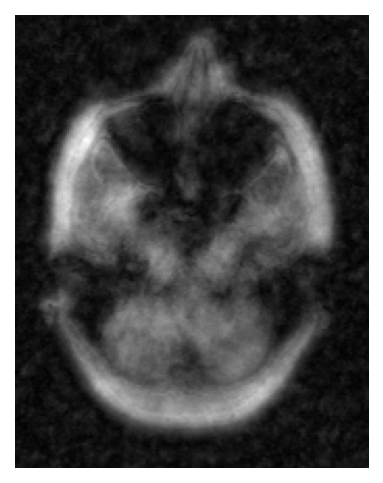

In [18]:
import matplotlib.pylab as plt
print("Zero-filled root sum of squares reconstruction")
plt.figure(dpi = 150)
plt.imshow(train,cmap = "gray")
plt.axis("off")
plt.show()

In [19]:
targ = targ.squeeze()
targ.shape

torch.Size([218, 170])

Zero-filled root sum of squares reconstruction


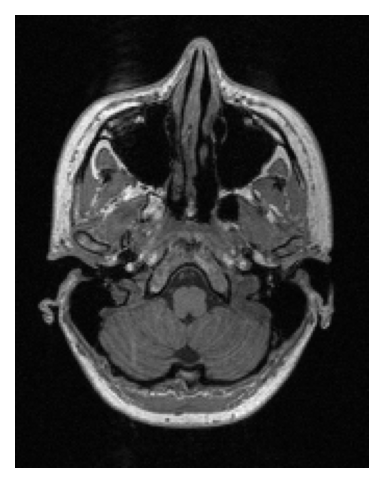

In [20]:
import matplotlib.pylab as plt
print("Zero-filled root sum of squares reconstruction")
plt.figure(dpi = 150)
plt.imshow(targ,cmap = "gray")
plt.axis("off")
plt.show()

In [27]:
train.shape

torch.Size([1, 1, 218, 170])

In [26]:
train = train.unsqueeze(dim=0)

In [28]:
y_pred = unet(train.to(device))

In [29]:
y_pred = y_pred.cpu().detach()
y_pred = y_pred.squeeze()
y_pred.shape

torch.Size([218, 170])

Zero-filled root sum of squares reconstruction


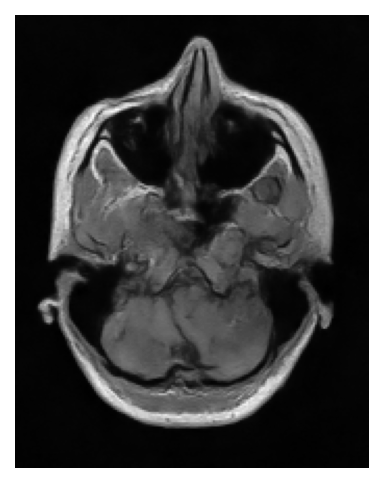

In [30]:
import matplotlib.pylab as plt
print("Zero-filled root sum of squares reconstruction")
plt.figure(dpi = 150)
plt.imshow(y_pred,cmap = "gray")
plt.axis("off")
plt.show()